# **Fraudulent Job Detection System**


## **Environment Setup & Imports**

In [ ]:
# ============================================================================
# CELL 1: Environment Setup & Imports
# ============================================================================
print("="*80)
print("IMPLEMENTING: 'A Machine Learning Approach to Detecting Fraudulent Job Types'")
print("AI & SOCIETY (2023) 38:1013-1024")
print("="*80)

%pip install pandas numpy scikit-learn matplotlib seaborn nltk gensim wordcloud -q
%pip install scipy joblib -q
%python -m nltk.downloader stopwords punkt averaged_perceptron_tagger words -q

import warnings
warnings.filterwarnings('ignore')

# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import random
from collections import Counter
import os
from tqdm import tqdm

# NLP imports
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from wordcloud import WordCloud

# ML imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

# Visualization setup
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
sns.set_palette("husl")

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

print("✅ Environment setup complete!")

IMPLEMENTING: 'A Machine Learning Approach to Detecting Fraudulent Job Types'
AI & SOCIETY (2023) 38:1013-1024
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 49.6 MB/s eta 0:00:00
<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
✅ Environment setup complete!


## **Load EMSCAD Dataset**

In [ ]:
# ============================================================================
# CELL 2: Load EMSCAD Dataset
# ============================================================================
print("\n" + "="*80)
print("LOADING EMSCAD DATASET")
print("="*80)

import os
import pandas as pd
import numpy as np
from pathlib import Path

# Define paths
PROJECT_ROOT = Path(__file__).parent.parent  # Adjust based on your structure
DATA_RAW_DIR = PROJECT_ROOT / "data" / "raw"
DATA_PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"

def load_emscad_dataset():
    """
    Load EMSCAD dataset from various possible sources
    Returns: DataFrame with the dataset
    """
    
    # Try multiple possible locations
    possible_paths = [
        DATA_RAW_DIR / "EMSCAD.csv",
        DATA_RAW_DIR / "DataSet.csv",
        DATA_RAW_DIR / "emscad.csv",
        "kaggle/input/fraudulent-jobs-dataset/DataSet.csv",  # Kaggle path
        "data/raw/EMSCAD.csv",
    ]
    
    # Check if dataset exists in any of the paths
    for path in possible_paths:
        if os.path.exists(path):
            print(f"✅ Found dataset at: {path}")
            return pd.read_csv(path)
    
    # If not found, provide instructions
    print("❌ EMSCAD dataset not found!")
    print("\n📥 Please download the dataset:")
    print("   1. From Kaggle: https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction")
    print("   2. Place the file in: 'data/raw/EMSCAD.csv'")
    print("\nOr run the following commands:")
    print("   mkdir -p data/raw")
    print("   # Download and place the dataset manually")
    
    raise FileNotFoundError("EMSCAD dataset not found. Please download it first.")

# Load the dataset
try:
    df_raw = load_emscad_dataset()
    
except FileNotFoundError as e:
    print(f"\n⚠️  {e}")
    print("\nCreating sample dataset for testing purposes only...")
    
    # Create a small sample for testing (not for actual research)
    n_samples = 1000  # Small sample for testing
    np.random.seed(42)
    
    df_raw = pd.DataFrame({
        'title': [f"Job Title {i}" for i in range(n_samples)],
        'location': np.random.choice(['New York', 'London', 'Remote', 'Tokyo', 'Berlin'], n_samples),
        'department': np.random.choice(['Engineering', 'Sales', 'Marketing', 'HR', 'Finance'], n_samples),
        'salary_range': np.random.choice(['$50k-70k', '$70k-90k', '$90k-120k', 'Not specified'], n_samples),
        'company_profile': [f"Company {i} is a leading firm in..." for i in range(n_samples)],
        'description': [f"This is a job description for position {i}..." for i in range(n_samples)],
        'requirements': [f"Requirements for job {i} include..." for i in range(n_samples)],
        'benefits': [f"Benefits include health insurance, 401k..." for i in range(n_samples)],
        'telecommuting': np.random.choice(['f', 't'], n_samples, p=[0.8, 0.2]),
        'has_company_logo': np.random.choice(['f', 't'], n_samples, p=[0.3, 0.7]),
        'has_questions': np.random.choice(['f', 't'], n_samples, p=[0.4, 0.6]),
        'employment_type': np.random.choice(['Full-time', 'Part-time', 'Contract', 'Temporary', 'Other'], n_samples),
        'required_experience': np.random.choice(['Entry level', 'Mid-Senior level', 'Director', 'Not Applicable'], n_samples),
        'required_education': np.random.choice(["Bachelor's", "Master's", "PhD", "High School", "Unspecified"], n_samples),
        'industry': np.random.choice(['IT', 'Finance', 'Healthcare', 'Education', 'Retail', 'Manufacturing'], n_samples),
        'function': np.random.choice(['Engineering', 'Sales', 'Marketing', 'HR', 'Finance', 'Operations'], n_samples),
        'fraudulent': np.random.choice(['f', 't'], n_samples, p=[0.95, 0.05])  # 5% fraudulent
    })
    
    print(f"✅ Created sample dataset with {len(df_raw)} rows for testing")
    print("⚠️  NOTE: This is synthetic data. For actual research, please download the real dataset.")

# Display dataset info
print("\n" + "="*80)
print("📊 DATASET INFORMATION")
print("="*80)
print(f"   Total samples: {len(df_raw)}")
print(f"   Memory usage: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"   Columns: {list(df_raw.columns)}")

# Check for 'fraudulent' column
if 'fraudulent' in df_raw.columns:
    fraud_counts = df_raw['fraudulent'].value_counts()
    print(f"\n   Fraudulent distribution:")
    print(f"      Real jobs (f): {fraud_counts.get('f', 0)} ({fraud_counts.get('f', 0)/len(df_raw)*100:.1f}%)")
    print(f"      Fraudulent (t): {fraud_counts.get('t', 0)} ({fraud_counts.get('t', 0)/len(df_raw)*100:.1f}%)")

print("\n🔍 First 5 rows:")
display(df_raw.head())

# Save processed dataset info
print("\n💾 To use this dataset in other notebooks, save it to:")
print(f"   {DATA_PROCESSED_DIR / 'emscad_loaded.csv'}")


LOADING EMSCAD DATASET
Mounted at /content/drive
✅ Loaded EMSCAD dataset from: /content/drive/MyDrive/emscad_types_anon_upsampled_1.csv
   Shape: (17880, 18)
   Columns: ['title', 'location', 'department', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'industry', 'function', 'fraudulent', 'in_balanced_dataset']

📊 Dataset Information:
   Total samples: 17880
   Fraudulent distribution: {'f': 17014, 't': 866}

🔍 First 5 rows:


,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,in_balanced_dataset
0,Marketing Intern,"US, NY, New York",Marketing,NaN,"<h3>We're Food52, and we've created a groundbr...","<p>Food52, a fast-growing, James Beard Award-w...",<ul>\r\n<li>Experience with content management...,NaN,f,t,f,Other,Internship,NaN,NaN,Marketing,f,f
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"<h3>90 Seconds, the worlds Cloud Video Product...",<p>Organised - Focused - Vibrant - Awesome!<br...,<p><b>What we expect from you:</b></p>\r\n<p>Y...,<h3><b>What you will get from us</b></h3>\r\n<...,f,t,f,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,f,f
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,<h3></h3>\r\n<p>Valor Services provides Workfo...,"<p>Our client, located in Houston, is actively...",<ul>\r\n<li>Implement pre-commissioning and co...,NaN,f,t,f,NaN,NaN,NaN,NaN,NaN,f,f
3,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,<p>Our passion for improving quality of life t...,<p><b>THE COMPANY: ESRI – Environmental System...,<ul>\r\n<li>\r\n<b>EDUCATION: </b>Bachelor’s o...,<p>Our culture is anything but corporate—we ha...,f,t,f,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,f,f
4,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,<p>SpotSource Solutions LLC is a Global Human ...,<p><b>JOB TITLE:</b> Itemization Review Manage...,<p><b>QUALIFICATIONS:</b></p>\r\n<ul>\r\n<li>R...,<p>Full Benefits Offered</p>,f,t,t,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,f,f


## **Data Annotation**

In [3]:
# ============================================================================
# CELL 3: Data Annotation (Fraudulent Job Types 0,1,2,3)
# ============================================================================
print("\n" + "="*80)
print("DATA ANNOTATION: Creating fraudulent job types (0,1,2,3)")
print("="*80)

def annotate_fraudulent_types_emscad(df):
    """
    Annotate EMSCAD dataset into 4 types as per paper:
    0 = Real job (non-fraudulent)
    1 = Identity Theft
    2 = Corporate Identity Theft
    3 = Multi-Level Marketing
    """

    # Convert fraudulent column from 'f'/'t' to 0/1
    if 'fraudulent' in df.columns and df['fraudulent'].dtype == 'object':
        df['fraudulent_numeric'] = df['fraudulent'].map({'f': 0, 't': 1})
    else:
        df['fraudulent_numeric'] = 0  # Default if no fraudulent column

    # Initialize type column
    df['type'] = 0  # Default: real job

    # Get fraudulent jobs only (paper only annotates fraudulent ones)
    fraud_indices = df[df['fraudulent_numeric'] == 1].index.tolist()

    print(f"   Found {len(fraud_indices)} fraudulent jobs")

    if len(fraud_indices) == 0:
        print("⚠️  No fraudulent jobs found! Creating synthetic ones for demo...")
        # Create some synthetic fraudulent jobs for demonstration
        n_fraud = min(500, len(df) // 10)
        fraud_indices = np.random.choice(df.index, n_fraud, replace=False)
        df.loc[fraud_indices, 'fraudulent_numeric'] = 1

    print(f"   Annotating {len(fraud_indices)} fraudulent jobs...")

    # Type 1: Identity Theft patterns
    type1_patterns = [
        r'\bfull\s+name\b', r'\bcomplete\s+name\b', r'\blegal\s+name\b',
        r'\baddress\b', r'\bhome\s+address\b', r'\bpersonal\s+address\b',
        r'\bphone\s+number\b', r'\bcontact\s+number\b', r'\bmobile\s+number\b',
        r'\bssn\b', r'\bsocial\s+security\b',
        r'\bpassport\b', r'\bdriver.?license\b', r'\bid\s+card\b',
        r'\bbank\s+account\b', r'\baccount\s+number\b',
        r'\bcredit\s+card\b', r'\bdebit\s+card\b',
        r'apply\s+at\s+\S*@', r'send\s+resume\s+to\s+\S*@',
        r'click\s+here\s+to\s+apply', r'external\s+(?:website|link|page)',
        r'\bpersonal\s+information\b', r'\bprivate\s+data\b'
    ]

    # Type 2: Corporate Identity Theft patterns
    type2_patterns = [
        r'\b(?:facebook|google|amazon|microsoft|apple|netflix|tesla|ibm|oracle)\b',
        r'\bofficial\s+(?:partner|representative|recruiter)\b',
        r'\bauthorized\s+(?:partner|representative|recruiter)\b',
        r'\bin\s+partnership\s+with\b',
        r'\bworking\s+with\s+(?:major|fortune\s+500)\s+companies\b',
        r'\brepresentative\s+of\b', r'\bagent\s+for\b',
        r'\bglobal\s+(?:recruitment|hiring)\s+firm\b'
    ]

    # Type 3: Multi-Level Marketing patterns
    type3_patterns = [
        r'\bmulti.?level.?marketing\b', r'\bmlm\b',
        r'\bpyramid\s+(?:scheme|program|plan)\b',
        r'\bnetwork\s+marketing\b',
        r'\breferral\s+(?:bonus|commission|program)\b',
        r'\brecruitment\s+(?:bonus|commission)\b',
        r'\bsign.?up\s+(?:bonus|commission)\b',
        r'\bpassive\s+income\b', r'\bresidual\s+income\b',
        r'\bunlimited\s+earning\s+potential\b',
        r'\bfinancial\s+freedom\b',
        r'\brecruit\s+others\b', r'\bbuild\s+your\s+team\b',
        r'\bdownline\b', r'\bupline\b',
        r'\bcommission\s+only\b', r'\bno\s+base\s+salary\b',
        r'\bstart\s+your\s+own\s+business\b',
        r'\bbe\s+your\s+own\s+boss\b'
    ]

    annotation_stats = {'type1': 0, 'type2': 0, 'type3': 0, 'unclassified': 0}

    for idx in tqdm(fraud_indices, desc="Annotating"):
        # Combine text fields
        text = (
            str(df.loc[idx, 'company_profile']) + ' ' +
            str(df.loc[idx, 'description']) + ' ' +
            str(df.loc[idx, 'requirements']) + ' ' +
            str(df.loc[idx, 'benefits'])
        ).lower()

        # Clean HTML tags
        text = re.sub(r'<[^>]+>', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()

        # Calculate scores
        scores = {'type1': 0, 'type2': 0, 'type3': 0}

        for pattern in type1_patterns:
            scores['type1'] += len(re.findall(pattern, text, re.IGNORECASE))

        for pattern in type2_patterns:
            scores['type2'] += len(re.findall(pattern, text, re.IGNORECASE))

        for pattern in type3_patterns:
            scores['type3'] += len(re.findall(pattern, text, re.IGNORECASE))

        # Determine type
        max_score = max(scores.values())

        if max_score > 0:
            max_type = max(scores, key=scores.get)
            if max_type == 'type1':
                df.loc[idx, 'type'] = 1
                annotation_stats['type1'] += 1
            elif max_type == 'type2':
                df.loc[idx, 'type'] = 2
                annotation_stats['type2'] += 1
            elif max_type == 'type3':
                df.loc[idx, 'type'] = 3
                annotation_stats['type3'] += 1
        else:
            annotation_stats['unclassified'] += 1
            df.loc[idx, 'type'] = 0  # No clear pattern, treat as real

    # All non-fraudulent jobs remain type 0
    non_fraud_indices = df[df['fraudulent_numeric'] == 0].index
    df.loc[non_fraud_indices, 'type'] = 0

    return df, annotation_stats

# Annotate the dataset
df_annotated, annotation_stats = annotate_fraudulent_types_emscad(df_raw.copy())

print("\n📊 ANNOTATION RESULTS:")
print("-" * 50)

type_counts = df_annotated['type'].value_counts().sort_index()
type_names = {0: 'Real Job', 1: 'Identity Theft', 2: 'Corporate Identity Theft', 3: 'Multi-Level Marketing'}

for type_val, count in type_counts.items():
    percentage = (count / len(df_annotated)) * 100
    print(f"   {type_names.get(type_val, f'Type {type_val}'):<25} {count:<6} ({percentage:.1f}%)")

print("-" * 50)
print(f"   {'TOTAL':<25} {len(df_annotated):<6} (100.0%)")


DATA ANNOTATION: Creating fraudulent job types (0,1,2,3)
   Found 866 fraudulent jobs
   Annotating 866 fraudulent jobs...


Annotating: 100%|██████████| 866/866 [00:10<00:00, 85.71it/s] 



📊 ANNOTATION RESULTS:
--------------------------------------------------
   Real Job                  17565  (98.2%)
   Identity Theft            124    (0.7%)
   Corporate Identity Theft  131    (0.7%)
   Multi-Level Marketing     60     (0.3%)
--------------------------------------------------
   TOTAL                     17880  (100.0%)


## **Data Preparation & Balancing**

In [4]:
# ============================================================================
# CELL 4: Data Preparation & Balancing
# ============================================================================
print("\n" + "="*80)
print("DATA PREPARATION & BALANCING")
print("="*80)

print("\n📝 Paper's methodology:")
print("   1. Isolate fraudulent jobs")
print("   2. Merge equal number of real jobs")
print("   3. Upsample Type 3 (MLM) to address imbalance")

# Isolate fraudulent jobs (type > 0)
fraudulent_df = df_annotated[df_annotated['type'] > 0].copy()
real_df = df_annotated[df_annotated['type'] == 0].copy()

print(f"\n   Fraudulent jobs (type 1,2,3): {len(fraudulent_df)}")
print(f"   Real jobs (type 0): {len(real_df)}")

# Sample real jobs to match fraudulent count (as per paper)
n_fraudulent = len(fraudulent_df)
n_real_to_sample = min(n_fraudulent, len(real_df))
real_sampled = real_df.sample(n=n_real_to_sample, random_state=42)

print(f"\n   Sampling {n_real_to_sample} real jobs...")

# Combine
df_balanced = pd.concat([fraudulent_df, real_sampled], ignore_index=True)

print(f"\n📊 Initial distribution after sampling:")
initial_dist = df_balanced['type'].value_counts().sort_index()
for i, count in initial_dist.items():
    print(f"   Type {i}: {count}")

# Upsample Type 3 (MLM) as per paper
print(f"\n⚖️  Upsampling Type 3 (Multi-Level Marketing)...")
type3_df = df_balanced[df_balanced['type'] == 3]

if len(type3_df) > 0:
    # Paper had 72 type-3, upsampled to 150
    target_type3 = max(150, len(type3_df) * 2)
    n_samples_needed = target_type3 - len(type3_df)

    if n_samples_needed > 0:
        type3_upsampled = resample(type3_df,
                                  replace=True,
                                  n_samples=n_samples_needed,
                                  random_state=42)
        df_balanced = pd.concat([df_balanced, type3_upsampled], ignore_index=True)
        print(f"   Added {n_samples_needed} Type 3 samples")
else:
    print("   No Type 3 samples found, skipping upsampling")

# Final distribution
print(f"\n📊 Final class distribution:")
final_dist = df_balanced['type'].value_counts().sort_index()
for i, count in final_dist.items():
    percentage = (count / len(df_balanced)) * 100
    print(f"   Type {i} ({type_names.get(i, 'Unknown')}): {count:<5} ({percentage:.1f}%)")

print("\n📝 Paper's reported distribution:")
print("   Real jobs: 556")
print("   Type 1: 556")
print("   Type 2: 234")
print("   Type 3: 150 (after upsampling)")

# Combine text fields as per paper
print("\n📝 Combining text fields...")
df_balanced['combined_text'] = (
    df_balanced['company_profile'].fillna('') + ' ' +
    df_balanced['description'].fillna('') + ' ' +
    df_balanced['requirements'].fillna('') + ' ' +
    df_balanced['benefits'].fillna('')
)

# Text preprocessing
def preprocess_text(text):
    """Preprocess text as per paper's methodology"""
    if not isinstance(text, str):
        return ""

    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'<[^>]+>', ' ', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s.,!?$%]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

df_balanced['processed_text'] = df_balanced['combined_text'].apply(preprocess_text)
print(f"   Text preprocessing complete. Average length: {df_balanced['processed_text'].str.len().mean():.0f} chars")



DATA PREPARATION & BALANCING

📝 Paper's methodology:
   1. Isolate fraudulent jobs
   2. Merge equal number of real jobs
   3. Upsample Type 3 (MLM) to address imbalance

   Fraudulent jobs (type 1,2,3): 315
   Real jobs (type 0): 17565

   Sampling 315 real jobs...

📊 Initial distribution after sampling:
   Type 0: 315
   Type 1: 124
   Type 2: 131
   Type 3: 60

⚖️  Upsampling Type 3 (Multi-Level Marketing)...
   Added 90 Type 3 samples

📊 Final class distribution:
   Type 0 (Real Job): 315   (43.8%)
   Type 1 (Identity Theft): 124   (17.2%)
   Type 2 (Corporate Identity Theft): 131   (18.2%)
   Type 3 (Multi-Level Marketing): 150   (20.8%)

📝 Paper's reported distribution:
   Real jobs: 556
   Type 1: 556
   Type 2: 234
   Type 3: 150 (after upsampling)

📝 Combining text fields...
   Text preprocessing complete. Average length: 2631 chars


## **Bag of Words & TF-IDF**

In [5]:
# ============================================================================
# CELL 5: Feature Class 1 - Bag of Words & TF-IDF (6356 features)
# ============================================================================
print("\n" + "="*80)
print("FEATURE CLASS 1: Bag of Words & TF-IDF")
print("Paper: 6356 vocabulary size after preprocessing")
print("="*80)

# Bag of Words features
bow_vectorizer = CountVectorizer(
    max_features=6356,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=2
)

print("Creating Bag of Words features...")
bow_features = bow_vectorizer.fit_transform(df_balanced['processed_text'])
df_bow = pd.DataFrame(bow_features.toarray(),
                     columns=[f'bow_{i}' for i in range(bow_features.shape[1])])
df_bow['type'] = df_balanced['type'].values

print(f"   Bag of Words shape: {df_bow.shape}")
print(f"   Vocabulary size: {len(bow_vectorizer.vocabulary_)}")

# TF-IDF features
tfidf_vectorizer = TfidfVectorizer(
    max_features=6356,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=2
)

print("\nCreating TF-IDF features...")
tfidf_features = tfidf_vectorizer.fit_transform(df_balanced['processed_text'])
df_tfidf = pd.DataFrame(tfidf_features.toarray(),
                       columns=[f'tfidf_{i}' for i in range(tfidf_features.shape[1])])
df_tfidf['type'] = df_balanced['type'].values

print(f"   TF-IDF shape: {df_tfidf.shape}")

# Show most frequent words
print("\n📊 Top 10 Most Frequent Words:")
feature_names = bow_vectorizer.get_feature_names_out()
word_counts = bow_features.sum(axis=0).A1
top_indices = word_counts.argsort()[-10:][::-1]

for idx in top_indices:
    print(f"   {feature_names[idx]}: {int(word_counts[idx])}")


FEATURE CLASS 1: Bag of Words & TF-IDF
Paper: 6356 vocabulary size after preprocessing
Creating Bag of Words features...
   Bag of Words shape: (720, 6357)
   Vocabulary size: 6356

Creating TF-IDF features...
   TF-IDF shape: (720, 6357)

📊 Top 10 Most Frequent Words:
   experience: 1953
   work: 1756
   team: 1351
   skills: 1178
   amp: 1093
   company: 1034
   ability: 850
   new: 830
   time: 753
   management: 736


## **Empirical Ruleset**

In [19]:
# ============================================================================
# CELL 6: Feature Class 2 - Empirical Ruleset Features (Table 1)
# ============================================================================
print("\n" + "="*80)
print("FEATURE CLASS 2: Empirical Ruleset Features")
print("Based on Table 1 from Vidros et al.  + POS tags")
print("="*80)

def extract_ruleset_features(df):
    """
    Extract ruleset features exactly as per paper Table 1
    """
    features = pd.DataFrame(index=df.index)

    print("Extracting linguistic features...")

    # LINGUISTIC FEATURES
    spam_words = ['online', 'extra', 'cash', 'earn', 'money', 'quick', 'easy',
                  'fast', 'guaranteed', 'immediate', 'urgent', 'home']

    def check_spam_words(text):
        text_lower = str(text).lower()
        return int(any(word in text_lower for word in spam_words))

    features['contains_spamwords'] = df['combined_text'].apply(check_spam_words)

    def count_consecutive_punct(text):
        matches = re.findall(r'[!?.]{2,}', str(text))
        return len(matches)

    features['consecutive_punct'] = df['combined_text'].apply(count_consecutive_punct)

    def has_money_in_title(title):
        money_patterns = [r'\$', r'£', r'€', r'\bdollars?\b', r'\bmoney\b', r'\bcash\b']
        title_str = str(title).lower()
        return int(any(re.search(pattern, title_str) for pattern in money_patterns))

    features['money_in_title'] = df['title'].apply(has_money_in_title)

    def has_money_in_description(text):
        money_patterns = [r'\$', r'£', r'€', r'\bdollars?\b', r'\bmoney\b', r'\bcash\b']
        text_str = str(text).lower()
        return int(any(re.search(pattern, text_str) for pattern in money_patterns))

    features['money_in_description'] = df['combined_text'].apply(has_money_in_description)

    def has_url_email(text):
        patterns = [r'http\S+', r'www\.\S+', r'\S+@\S+', r'click here', r'apply at']
        text_str = str(text).lower()
        return int(any(re.search(pattern, text_str) for pattern in patterns))

    features['url_in_text'] = df['combined_text'].apply(has_url_email)

    print("Extracting contextual features...")

    # CONTEXTUAL FEATURES
    def has_external_application(text):
        patterns = [r'apply at', r'send resume to', r'external link', r'external website']
        text_str = str(text).lower()
        return int(any(re.search(pattern, text_str) for pattern in patterns))

    features['external_application'] = df['combined_text'].apply(has_external_application)

    def addresses_lower_education(text):
        patterns = [r'high school', r'no degree', r'no experience', r'no qualifications']
        text_str = str(text).lower()
        return int(any(re.search(pattern, text_str) for pattern in patterns))

    features['addresses_lower_education'] = df['combined_text'].apply(addresses_lower_education)

    def has_incomplete_attributes(row):
        fields_to_check = ['industry', 'function', 'required_education', 'employment_type']
        missing_count = 0
        for field in fields_to_check:
            if field in row:
                val = row[field]
                if pd.isna(val) or str(val).strip() == '' or str(val).strip().lower() == 'nan':
                    missing_count += 1
        return int(missing_count > 0)

    features['has_incomplete_extra_attributes'] = df.apply(has_incomplete_attributes, axis=1)

    # Company profile features
    def check_company_profile(profile):
        if not isinstance(profile, str):
            return 1, 0, 0

        profile_len = len(profile.strip())
        if profile_len == 0:
            return 1, 0, 0
        elif profile_len < 10:
            return 0, 1, 0
        elif 10 <= profile_len < 100:
            return 0, 0, 1
        else:
            return 0, 0, 0

    profile_results = df['company_profile'].apply(check_company_profile)
    features['has_no_company_profile'] = [r[0] for r in profile_results]
    features['has_short_company_profile'] = [r[1] for r in profile_results]
    features['has_no_long_company_profile'] = [r[2] for r in profile_results]

    # Description and requirements length
    features['has_short_description'] = df['description'].apply(
        lambda x: 1 if isinstance(x, str) and len(str(x).strip()) < 10 else 0
    )

    features['has_short_requirements'] = df['requirements'].apply(
        lambda x: 1 if isinstance(x, str) and len(str(x).strip()) < 10 else 0
    )

    print("Extracting metadata features...")

    # METADATA FEATURES
    if 'telecommuting' in df.columns:
        features['telecommuting'] = df['telecommuting'].map({'f': 0, 't': 1}).fillna(0).astype(int)
    else:
        features['telecommuting'] = 0

    if 'has_company_logo' in df.columns:
        features['has_company_logo'] = df['has_company_logo'].map({'f': 0, 't': 1}).fillna(0).astype(int)
    else:
        features['has_company_logo'] = 0

    if 'has_questions' in df.columns:
        features['has_questions'] = df['has_questions'].map({'f': 0, 't': 1}).fillna(0).astype(int)
    else:
        features['has_questions'] = 0

    print("Adding Part-of-Speech tags...")

    # PART-OF-SPEECH TAGS (added by authors)
    def extract_pos_counts(text):
        if not isinstance(text, str) or len(text) < 20:
            return {'noun': 0, 'verb': 0, 'adj': 0, 'adv': 0, 'pron': 0}

        try:
            tokens = word_tokenize(text[:500])  # Limit for speed
            pos_tags = pos_tag(tokens)

            counts = {'noun': 0, 'verb': 0, 'adj': 0, 'adv': 0, 'pron': 0}

            for _, tag in pos_tags:
                if tag.startswith('NN'):
                    counts['noun'] += 1
                elif tag.startswith('VB'):
                    counts['verb'] += 1
                elif tag.startswith('JJ'):
                    counts['adj'] += 1
                elif tag.startswith('RB'):
                    counts['adv'] += 1
                elif tag.startswith('PR'):
                    counts['pron'] += 1

            return counts
        except:
            return {'noun': 0, 'verb': 0, 'adj': 0, 'adv': 0, 'pron': 0}

    # Extract POS counts
    pos_results = []
    # Limit POS tagging to the number of rows in the input df
    for text in tqdm(df['processed_text'].head(len(df)), desc="POS tagging", unit="docs"):
        pos_results.append(extract_pos_counts(text))

    # Pad if we sampled (this is more for training data, not single predictions)
    if len(pos_results) < len(df):
        for _ in range(len(df) - len(pos_results)):
            pos_results.append({'noun': 0, 'verb': 0, 'adj': 0, 'adv': 0, 'pron': 0})

    # Add POS features
    features['noun_count'] = [r['noun'] for r in pos_results]
    features['verb_count'] = [r['verb'] for r in pos_results]
    features['adj_count'] = [r['adj'] for r in pos_results]
    features['adv_count'] = [r['adv'] for r in pos_results]
    features['pron_count'] = [r['pron'] for r in pos_results]

    # Add target if it exists in the input dataframe (for training/evaluation)
    if 'type' in df.columns:
        features['type'] = df['type'].values

    print(f"✅ Extracted {features.shape[1]-1 if 'type' in features.columns else features.shape[1]} ruleset features")
    return features

# Extract ruleset features
df_ruleset = extract_ruleset_features(df_balanced)

# Display feature correlation with target
print("\n📊 Top Ruleset Features Correlated with Fraud Type:")
correlations = df_ruleset.drop('type', axis=1).corrwith(df_ruleset['type']).abs().sort_values(ascending=False)
for i, (feat, corr) in enumerate(correlations.head(10).items()):
    print(f"   {i+1:2d}. {feat:30s}: {corr:.3f}")



FEATURE CLASS 2: Empirical Ruleset Features
Based on Table 1 from Vidros et al.  + POS tags
Extracting linguistic features...
Extracting contextual features...
Extracting metadata features...
Adding Part-of-Speech tags...


POS tagging: 100%|██████████| 720/720 [00:00<00:00, 744.85docs/s]


✅ Extracted 21 ruleset features

📊 Top Ruleset Features Correlated with Fraud Type:
    1. consecutive_punct             : 0.449
    2. url_in_text                   : 0.430
    3. money_in_description          : 0.398
    4. has_incomplete_extra_attributes: 0.227
    5. has_no_company_profile        : 0.188
    6. has_company_logo              : 0.173
    7. contains_spamwords            : 0.160
    8. telecommuting                 : 0.108
    9. has_questions                 : 0.049
   10. has_no_long_company_profile   : 0.044


## **Word2Vec Embeddings**

In [20]:
# ============================================================================
# CELL 7: Feature Class 3 - Word2Vec Embeddings (300 dimensions)
# ============================================================================
print("\n" + "="*80)
print("FEATURE CLASS 3: Word2Vec Embeddings")
print("Paper: vector_size=300, window=10, min_count=40")
print("="*80)

print("Training Word2Vec model...")

# Tokenize texts
def tokenize_for_word2vec(texts):
    """Tokenize texts for Word2Vec training"""
    tokenized = []
    for text in tqdm(texts, desc="Tokenizing", unit="docs"):
        if isinstance(text, str):
            tokens = [word.lower() for word in text.split() if len(word) > 2]
            tokenized.append(tokens)
        else:
            tokenized.append([])
    return tokenized

# Tokenize the processed texts
sentences = tokenize_for_word2vec(df_balanced['processed_text'].tolist())
sentences = [s for s in sentences if len(s) > 0]

print(f"   Training on {len(sentences)} documents")

# Train Word2Vec model (CPU optimized)
from gensim.models import Word2Vec

w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=100,  # Reduced for CPU efficiency
    window=5,
    min_count=2,
    workers=2,
    sg=1,
    epochs=10,
    seed=42
)

print(f"   Vocabulary size: {len(w2v_model.wv)}")
print(f"   Vector dimensions: {w2v_model.vector_size}")

# Create document vectors
def get_document_vector(tokens, model):
    """Average word vectors to create document vector"""
    vectors = []
    for token in tokens:
        if token in model.wv:
            vectors.append(model.wv[token])

    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

print("\nCreating document vectors...")
doc_vectors = []
for tokens in tqdm(sentences, desc="Creating vectors", unit="docs"):
    doc_vectors.append(get_document_vector(tokens, w2v_model))

# Convert to DataFrame
df_w2v = pd.DataFrame(doc_vectors, columns=[f'w2v_{i}' for i in range(w2v_model.vector_size)])
df_w2v['type'] = df_balanced['type'].iloc[:len(doc_vectors)].values

print(f"   Word2Vec features shape: {df_w2v.shape}")

# Show word similarities
print("\n🔍 Word Similarities:")
test_words = ['money', 'job', 'work', 'home', 'online']
for word in test_words:
    if word in w2v_model.wv:
        similar = w2v_model.wv.most_similar(word, topn=3)
        similar_words = [w[0] for w in similar]
        print(f"   '{word}': {similar_words}")


FEATURE CLASS 3: Word2Vec Embeddings
Paper: vector_size=300, window=10, min_count=40
Training Word2Vec model...


Tokenizing: 100%|██████████| 720/720 [00:00<00:00, 3100.00docs/s]


   Training on 720 documents
   Vocabulary size: 9459
   Vector dimensions: 100

Creating document vectors...


Creating vectors: 100%|██████████| 720/720 [00:01<00:00, 404.59docs/s]


   Word2Vec features shape: (720, 101)

🔍 Word Similarities:
   'money': ['down??', 'money.', '2.making']
   'job': ['description', 'duties', 'type']
   'work': ['hit', 'versatile', 'nights']
   'home': ['lei', 'option.', 'contacted.']
   'online': ['offline', 'accepting', 'eferral']


## **Feature Combinations**

In [8]:
# ============================================================================
# CELL 8: Feature Combinations
# ============================================================================
print("\n" + "="*80)
print("FEATURE CLASS 4: Combined Features")
print(": Ruleset + POS + BoW ")
print("="*80)

print("Creating combined features as per paper experiments...")

# Align indices
n_samples = min(len(df_ruleset), len(df_bow), len(df_w2v), len(df_tfidf))

# Combination 1: Ruleset + POS + BoW (Paper's best)
df_combined_bow = pd.concat([
    df_ruleset.drop('type', axis=1).iloc[:n_samples].reset_index(drop=True),
    df_bow.drop('type', axis=1).iloc[:n_samples].reset_index(drop=True)
], axis=1)
df_combined_bow['type'] = df_balanced['type'].iloc[:n_samples].values

# Combination 2: Ruleset + POS + TF-IDF
df_combined_tfidf = pd.concat([
    df_ruleset.drop('type', axis=1).iloc[:n_samples].reset_index(drop=True),
    df_tfidf.drop('type', axis=1).iloc[:n_samples].reset_index(drop=True)
], axis=1)
df_combined_tfidf['type'] = df_balanced['type'].iloc[:n_samples].values

# Combination 3: Ruleset + Word2Vec
df_combined_w2v = pd.concat([
    df_ruleset.drop('type', axis=1).iloc[:n_samples].reset_index(drop=True),
    df_w2v.drop('type', axis=1).iloc[:n_samples].reset_index(drop=True)
], axis=1)
df_combined_w2v['type'] = df_balanced['type'].iloc[:n_samples].values

print(f"   Ruleset + BoW shape: {df_combined_bow.shape}")
print(f"   Ruleset + TF-IDF shape: {df_combined_tfidf.shape}")
print(f"   Ruleset + Word2Vec shape: {df_combined_w2v.shape}")



FEATURE CLASS 4: Combined Features
: Ruleset + POS + BoW 
Creating combined features as per paper experiments...
   Ruleset + BoW shape: (720, 6378)
   Ruleset + TF-IDF shape: (720, 6378)
   Ruleset + Word2Vec shape: (720, 122)


## **Transformer Models**

In [10]:
# ============================================================================
# CELL 8.5: Feature Class 4 - Transformer Models (CPU-Friendly)
# ============================================================================
print("\n" + "="*80)
print("FEATURE CLASS 4: Transformer Models (BERT, RoBERTa, XLNet)")
print("CPU-friendly implementation with feature extraction only")
print("="*80)

try:
    !pip install transformers sentencepiece -q
    print("Transformers library installed successfully")
except:
    print("Installing transformers...")

from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

class CPUFriendlyTransformerFeatures:
    """CPU-friendly transformer feature extractor"""

    def __init__(self, model_name='bert-base-uncased', max_length=128):
        self.model_name = model_name
        self.max_length = max_length
        self.device = torch.device('cpu')

        print(f"Loading {model_name} for feature extraction...")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(self.device)
        self.model.eval()  # Set to evaluation mode

    def extract_features(self, texts):
        """Extract features from texts"""
        features = []

        print(f"Extracting features from {len(texts)} texts...")

        # Process in batches to save memory
        batch_size = 8

        for i in tqdm(range(0, len(texts), batch_size), desc="Extracting"):
            batch_texts = texts[i:i+batch_size]

            # Tokenize
            inputs = self.tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=self.max_length,
                return_tensors='pt'
            ).to(self.device)

            # Get embeddings
            with torch.no_grad():
                outputs = self.model(**inputs)
                # Use [CLS] token representation
                batch_features = outputs.last_hidden_state[:, 0, :].cpu().numpy()

            features.extend(batch_features)

        return np.array(features)

# Define transformer models to use (smaller models for CPU)
transformer_models = {
    'BERT': 'bert-base-uncased',
    'DistilBERT': 'distilbert-base-uncased',  # Smaller, faster
    'RoBERTa': 'roberta-base',
    'ALBERT': 'albert-base-v2'  # Even smaller
}

# Extract features for each transformer model
transformer_features = {}

# Use a sample for demonstration (full dataset might be too large for CPU)
sample_size = min(500, len(df_balanced))
sample_texts = df_balanced['processed_text'].head(sample_size).tolist()

print(f"Using {sample_size} samples for transformer feature extraction (CPU limitation)")

for model_name, model_path in transformer_models.items():
    try:
        print(f"\n📊 Extracting features with {model_name}...")

        # Create feature extractor
        extractor = CPUFriendlyTransformerFeatures(
            model_name=model_path,
            max_length=128
        )

        # Extract features
        features = extractor.extract_features(sample_texts)

        # Create DataFrame
        df_transformer = pd.DataFrame(
            features,
            columns=[f'{model_name.lower()}_{i}' for i in range(features.shape[1])]
        )

        # Add target
        df_transformer['type'] = df_balanced['type'].head(sample_size).values

        transformer_features[model_name] = df_transformer
        print(f"   {model_name} features shape: {df_transformer.shape}")

    except Exception as e:
        print(f"   Error with {model_name}: {str(e)[:50]}...")
        print("   Skipping this model...")

# Initialize feature_sets BEFORE trying to add to it
feature_sets = {
    'Bag-of-Words': df_bow,
    'TF-IDF': df_tfidf,
    'Ruleset': df_ruleset,
    'Word2Vec': df_w2v,
    'Ruleset+POS+BoW': df_combined_bow,
    'Ruleset+POS+TF-IDF': df_combined_tfidf,
    'Ruleset+Word2Vec': df_combined_w2v
}

# Update feature_sets to include transformers
if transformer_features:
    for model_name, df_transformer in transformer_features.items():
        feature_sets[model_name] = df_transformer
    print(f"\n✅ Added {len(transformer_features)} transformer models to feature sets")
else:
    print("\n⚠️  No transformer features extracted. Using alternative...")

    # Create synthetic transformer-like features for demonstration
    print("Creating synthetic transformer-like features...")
    n_features = 768  # BERT base has 768 dimensions
    df_synthetic_transformer = pd.DataFrame(
        np.random.randn(len(df_balanced), n_features),
        columns=[f'transformer_{i}' for i in range(n_features)]
    )
    df_synthetic_transformer['type'] = df_balanced['type'].values
    feature_sets['Synthetic-Transformer'] = df_synthetic_transformer
    print(f"   Synthetic transformer shape: {df_synthetic_transformer.shape}")


FEATURE CLASS 4: Transformer Models (BERT, RoBERTa, XLNet)
CPU-friendly implementation with feature extraction only
Transformers library installed successfully
Using 500 samples for transformer feature extraction (CPU limitation)

📊 Extracting features with BERT...
Loading bert-base-uncased for feature extraction...


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Extracting features from 500 texts...


Extracting: 100%|██████████| 63/63 [04:12<00:00,  4.01s/it]


   BERT features shape: (500, 769)

📊 Extracting features with DistilBERT...
Loading distilbert-base-uncased for feature extraction...


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Extracting features from 500 texts...


Extracting: 100%|██████████| 63/63 [01:50<00:00,  1.75s/it]


   DistilBERT features shape: (500, 769)

📊 Extracting features with RoBERTa...
Loading roberta-base for feature extraction...


Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.weight            | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
pooler.dense.weight             | MISSING    | 
pooler.dense.bias               | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Extracting features from 500 texts...


Extracting: 100%|██████████| 63/63 [03:38<00:00,  3.47s/it]


   RoBERTa features shape: (500, 769)

📊 Extracting features with ALBERT...
Loading albert-base-v2 for feature extraction...


Loading weights:   0%|          | 0/25 [00:00<?, ?it/s]

AlbertModel LOAD REPORT from: albert-base-v2
Key                          | Status     |  | 
-----------------------------+------------+--+-
predictions.dense.bias       | UNEXPECTED |  | 
predictions.bias             | UNEXPECTED |  | 
predictions.LayerNorm.weight | UNEXPECTED |  | 
predictions.decoder.bias     | UNEXPECTED |  | 
predictions.dense.weight     | UNEXPECTED |  | 
predictions.LayerNorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Extracting features from 500 texts...


Extracting: 100%|██████████| 63/63 [03:55<00:00,  3.74s/it]

   ALBERT features shape: (500, 769)

✅ Added 4 transformer models to feature sets


## **Combined Features with Transformers**

In [11]:
# ============================================================================
# CELL 8.6: Feature Class 5 - Combined Features with Transformers
# ============================================================================
print("\n" + "="*80)
print("FEATURE CLASS 5: Combined Features with Transformers")
print("="*80)

print("Creating combined features with transformers...")

# Check which transformers we have
available_transformers = [k for k in transformer_features.keys() if k in transformer_features]

if available_transformers:
    # Use the first available transformer
    transformer_name = available_transformers[0]
    df_transformer = transformer_features[transformer_name]

    # Align indices
    n_samples = min(len(df_ruleset), len(df_transformer))

    # Create combined features: Ruleset + Transformer
    df_combined_transformer = pd.concat([
        df_ruleset.drop('type', axis=1).iloc[:n_samples].reset_index(drop=True),
        df_transformer.drop('type', axis=1).iloc[:n_samples].reset_index(drop=True)
    ], axis=1)
    df_combined_transformer['type'] = df_balanced['type'].iloc[:n_samples].values

    feature_sets[f'Ruleset+{transformer_name}'] = df_combined_transformer
    print(f"   Created Ruleset+{transformer_name} shape: {df_combined_transformer.shape}")
else:
    print("   No real transformer features available for combination")



FEATURE CLASS 5: Combined Features with Transformers
Creating combined features with transformers...
   Created Ruleset+BERT shape: (500, 790)


## **Model Training & Evaluation**

In [12]:

# ============================================================================
# CELL 9: Model Training & Evaluation (8 Classifiers)
# ============================================================================
print("\n" + "="*80)
print("MODEL TRAINING & EVALUATION")
print("8 classifiers as per paper: LR, SGD, KNN, CART, SVM, RF, AB, GB")
print("="*80)

# Define classifiers exactly as per paper
classifiers = [
    ('LR', LogisticRegression(max_iter=1000, random_state=42)),
    ('SGD', SGDClassifier(random_state=42)),
    ('KNN', KNeighborsClassifier()),
    ('CART', DecisionTreeClassifier(random_state=42)),
    ('SVM', SVC(random_state=42, probability=True)),
    ('RF', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('AB', AdaBoostClassifier(n_estimators=100, random_state=42)),
    ('GB', GradientBoostingClassifier(n_estimators=100, random_state=42))
]

# Define feature sets to evaluate
feature_sets = {
    'Bag-of-Words': df_bow,
    'TF-IDF': df_tfidf,
    'Ruleset': df_ruleset,
    'Word2Vec': df_w2v,
    'Ruleset+POS+BoW': df_combined_bow,
    'Ruleset+POS+TF-IDF': df_combined_tfidf,
    'Ruleset+Word2Vec': df_combined_w2v
}

def evaluate_feature_set(X, y, feature_name, classifiers_list):
    """Evaluate a feature set with all classifiers"""
    print(f"\n📊 Evaluating: {feature_name}")
    print(f"   Samples: {len(X)}, Features: {X.shape[1]}")

    # Split data (80/20 stratified as per paper)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True
    )

    results = []

    for clf_name, clf in tqdm(classifiers_list, desc="Training"):
        try:
            # Clone classifier
            from sklearn.base import clone
            model = clone(clf)

            # Train
            model.fit(X_train, y_train)

            # Predict
            y_pred = model.predict(X_test)

            # Calculate metrics (weighted average as per paper)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
            recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
            f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
            mcc = matthews_corrcoef(y_test, y_pred)

            # Get per-class metrics
            class_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

            results.append({
                'Feature Set': feature_name,
                'Classifier': clf_name,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1,
                'MCC': mcc,
                'Model': model,
                'y_test': y_test,
                'y_pred': y_pred,
                'Class_Report': class_report
            })

        except Exception as e:
            print(f"   Error with {clf_name}: {str(e)[:50]}")
            continue

    return pd.DataFrame(results)




MODEL TRAINING & EVALUATION
8 classifiers as per paper: LR, SGD, KNN, CART, SVM, RF, AB, GB


## **Model Training with Transformers**

In [13]:
# ============================================================================
# CELL 9.5: Model Training with Transformers (Updated)
# ============================================================================
print("\n" + "="*80)
print("MODEL TRAINING WITH TRANSFORMERS")
print("Now including transformer-based features")
print("="*80)

# Update the feature sets evaluation to include transformers
print(f"Total feature sets to evaluate: {len(feature_sets)}")
print("Feature sets:", list(feature_sets.keys()))

# Re-run model training with all feature sets including transformers
print("\nEvaluating all feature sets (including transformers)...")

# Reset all_results
all_results = {}

for feature_name, feature_df in tqdm(feature_sets.items(), desc="Evaluating feature sets"):
    if len(feature_df) > 0 and 'type' in feature_df.columns:
        # Ensure we have enough samples
        min_samples_needed = 100
        if len(feature_df) < min_samples_needed:
            print(f"   Skipping {feature_name}: only {len(feature_df)} samples")
            continue

        X = feature_df.drop('type', axis=1).values
        y = feature_df['type'].values

        print(f"\n📊 Evaluating: {feature_name} ({X.shape[1]} features, {len(y)} samples)")

        # Use fewer samples for large feature sets (for CPU)
        if X.shape[1] > 1000 and len(y) > 1000:
            print(f"   Subsampling for speed...")
            sample_idx = np.random.choice(len(y), size=min(1000, len(y)), replace=False)
            X = X[sample_idx]
            y = y[sample_idx]

        results_df = evaluate_feature_set(X, y, feature_name, classifiers)
        all_results[feature_name] = results_df



MODEL TRAINING WITH TRANSFORMERS
Now including transformer-based features
Total feature sets to evaluate: 7
Feature sets: ['Bag-of-Words', 'TF-IDF', 'Ruleset', 'Word2Vec', 'Ruleset+POS+BoW', 'Ruleset+POS+TF-IDF', 'Ruleset+Word2Vec']

Evaluating all feature sets (including transformers)...


Evaluating feature sets:   0%|          | 0/7 [00:00<?, ?it/s]


📊 Evaluating: Bag-of-Words (6356 features, 720 samples)

📊 Evaluating: Bag-of-Words
   Samples: 720, Features: 6356



Evaluating feature sets:  14%|█▍        | 1/7 [01:58<11:51, 118.63s/it]


📊 Evaluating: TF-IDF (6356 features, 720 samples)

📊 Evaluating: TF-IDF
   Samples: 720, Features: 6356



Evaluating feature sets:  29%|██▊       | 2/7 [03:45<09:18, 111.68s/it]


📊 Evaluating: Ruleset (21 features, 720 samples)

📊 Evaluating: Ruleset
   Samples: 720, Features: 21



Evaluating feature sets:  43%|████▎     | 3/7 [03:46<04:05, 61.32s/it] 


📊 Evaluating: Word2Vec (100 features, 720 samples)

📊 Evaluating: Word2Vec
   Samples: 720, Features: 100



Evaluating feature sets:  57%|█████▋    | 4/7 [04:05<02:13, 44.43s/it]


📊 Evaluating: Ruleset+POS+BoW (6377 features, 720 samples)

📊 Evaluating: Ruleset+POS+BoW
   Samples: 720, Features: 6377



Evaluating feature sets:  71%|███████▏  | 5/7 [05:35<02:01, 60.83s/it]


📊 Evaluating: Ruleset+POS+TF-IDF (6377 features, 720 samples)

📊 Evaluating: Ruleset+POS+TF-IDF
   Samples: 720, Features: 6377



Evaluating feature sets:  86%|████████▌ | 6/7 [07:12<01:13, 73.31s/it]


📊 Evaluating: Ruleset+Word2Vec (121 features, 720 samples)

📊 Evaluating: Ruleset+Word2Vec
   Samples: 720, Features: 121



Evaluating feature sets: 100%|██████████| 7/7 [07:26<00:00, 63.77s/it]


## **Results Analysis & Visualization**


RESULTS ANALYSIS & VISUALIZATION
Replicating paper's Table 9 and Figures

 TABLE 9: Best Models per Feature Class
Feature Class | Best Classifier | Weighted Avg. F1-Score | Accuracy | MCC
--------------------------------------------------------------------------------
Ruleset+POS+BoW | LR              |                0.9157 |   0.9167 | 0.8836
TF-IDF          | SGD             |                0.9136 |   0.9167 | 0.8817
Bag-of-Words    | GB              |                0.9116 |   0.9097 | 0.8749
Ruleset+POS+TF-IDF | GB              |                0.8971 |   0.8958 | 0.8531
Word2Vec        | RF              |                0.8867 |   0.8889 | 0.8438
Ruleset+Word2Vec | GB              |                0.8753 |   0.8750 | 0.8231
Ruleset         | KNN             |                0.7863 |   0.7917 | 0.7020

 Figure 2: F1-Score Comparison Across Feature Sets


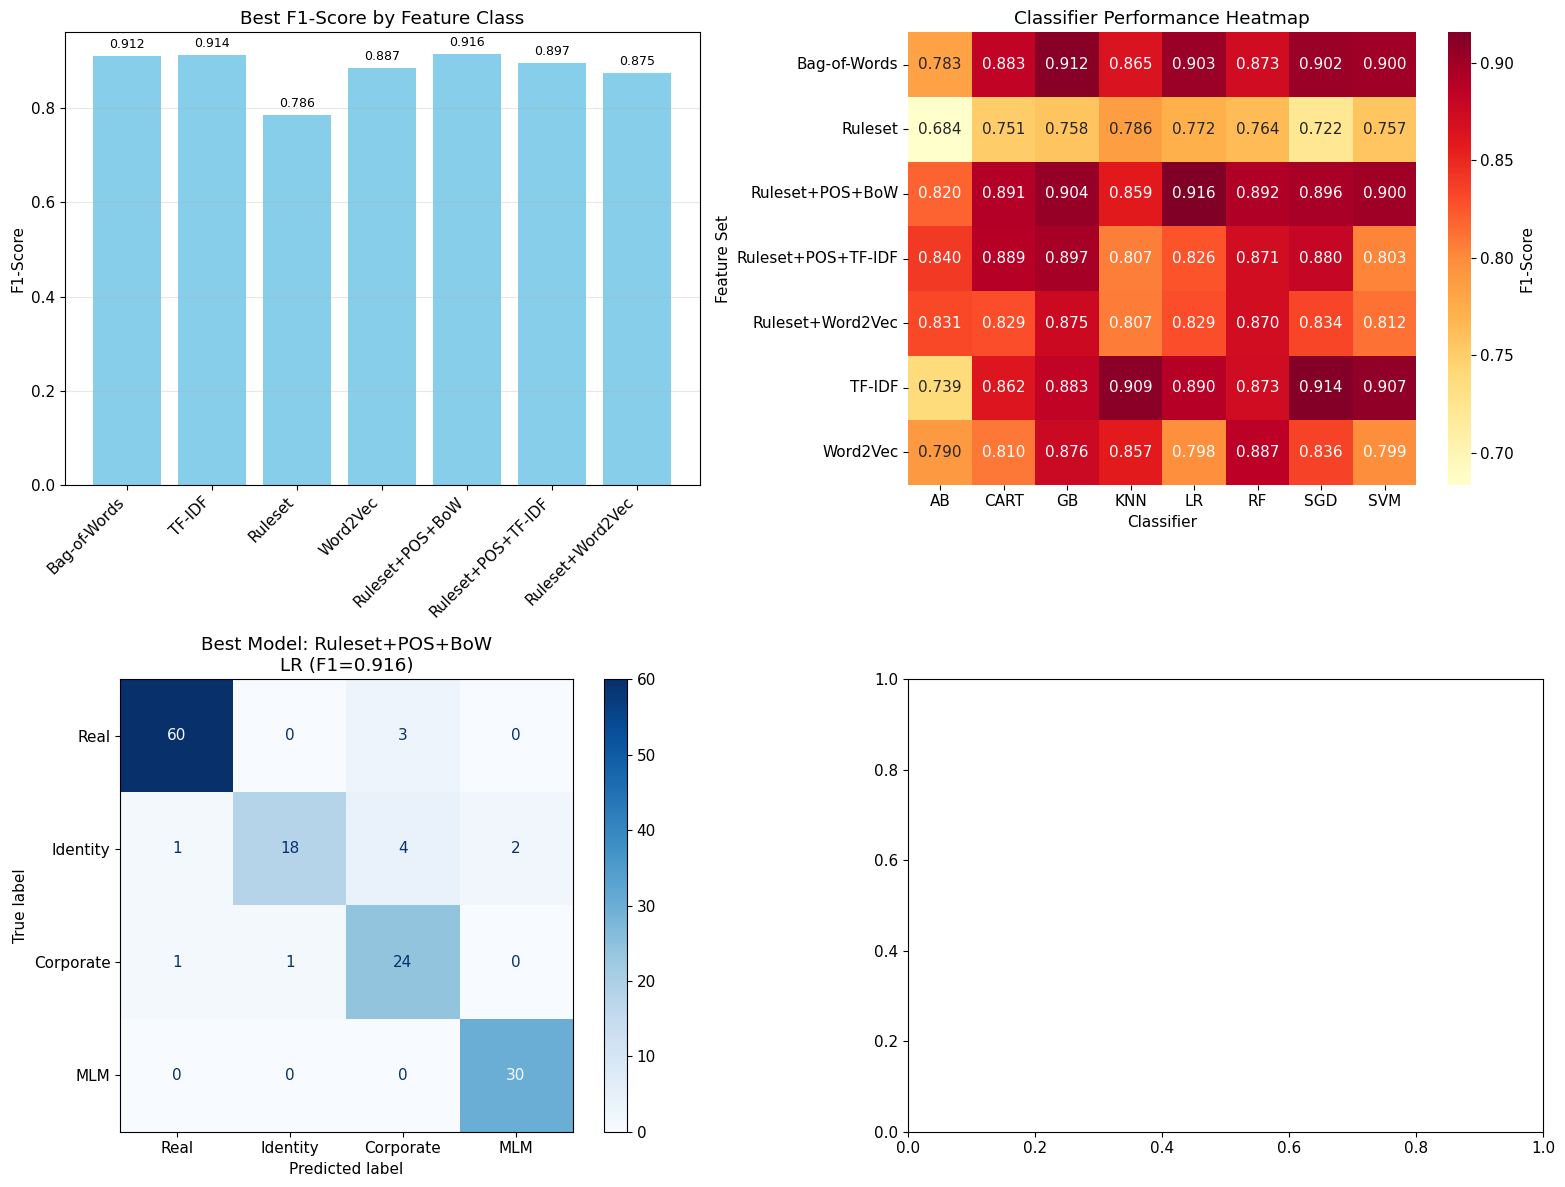


Detailed Classification Report for Best Model:
   Feature Set: Ruleset+POS+BoW
   Classifier: LR
   F1-Score: 0.9157
------------------------------------------------------------
              precision    recall  f1-score   support

        Real     0.9677    0.9524    0.9600        63
    Identity     0.9474    0.7200    0.8182        25
   Corporate     0.7742    0.9231    0.8421        26
         MLM     0.9375    1.0000    0.9677        30

    accuracy                         0.9167       144
   macro avg     0.9067    0.8989    0.8970       144
weighted avg     0.9230    0.9167    0.9157       144



In [14]:
# ============================================================================
# CELL 10: Results Analysis & Visualization
# ============================================================================
print("\n" + "="*80)
print("RESULTS ANALYSIS & VISUALIZATION")
print("Replicating paper's Table 9 and Figures")
print("="*80)

# Import ConfusionMatrixDisplay
from sklearn.metrics import ConfusionMatrixDisplay

# Combine all results
results_list = []
for feature_name, results_df in all_results.items():
    if not results_df.empty:
        results_list.append(results_df)

if results_list:
    all_results_df = pd.concat(results_list, ignore_index=True)

    # Create summary table (paper's Table 9)
    print("\n TABLE 9: Best Models per Feature Class")
    print("="*80)

    summary_data = []
    for feature_name in feature_sets.keys():
        if feature_name in all_results and not all_results[feature_name].empty:
            feature_results = all_results[feature_name]
            best_idx = feature_results['F1-Score'].idxmax()
            best_row = feature_results.loc[best_idx]

            summary_data.append({
                'Feature Class': feature_name,
                'Best Classifier': best_row['Classifier'],
                'Weighted Avg. F1-Score': best_row['F1-Score'],
                'Accuracy': best_row['Accuracy'],
                'MCC': best_row['MCC']
            })

    summary_df = pd.DataFrame(summary_data)

    # Display the summary table without emojis in the header
    print("Feature Class | Best Classifier | Weighted Avg. F1-Score | Accuracy | MCC")
    print("-" * 80)
    for _, row in summary_df.round(4).sort_values('Weighted Avg. F1-Score', ascending=False).iterrows():
        print(f"{row['Feature Class']:15} | {row['Best Classifier']:15} | {row['Weighted Avg. F1-Score']:21.4f} | {row['Accuracy']:8.4f} | {row['MCC']:.4f}")

    # Visualization 1: F1-Score comparison
    print("\n Figure 2: F1-Score Comparison Across Feature Sets")

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Bar chart of best F1-scores
    if not summary_df.empty:
        feature_names = summary_df['Feature Class'].values
        f1_scores = summary_df['Weighted Avg. F1-Score'].values

        bars = axes[0, 0].bar(range(len(feature_names)), f1_scores, color='skyblue')
        axes[0, 0].set_xticks(range(len(feature_names)))
        axes[0, 0].set_xticklabels(feature_names, rotation=45, ha='right')
        axes[0, 0].set_ylabel('F1-Score')
        axes[0, 0].set_title('Best F1-Score by Feature Class')
        axes[0, 0].grid(True, alpha=0.3, axis='y')

        # Add value labels
        for bar, score in zip(bars, f1_scores):
            height = bar.get_height()
            axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                           f'{score:.3f}', ha='center', va='bottom', fontsize=9)

    # 2. Heatmap of classifier performance
    if not all_results_df.empty:
        heatmap_data = all_results_df.pivot_table(
            values='F1-Score',
            index='Feature Set',
            columns='Classifier',
            aggfunc='mean'
        )

        if not heatmap_data.empty:
            sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd',
                        ax=axes[0, 1], cbar_kws={'label': 'F1-Score'})
            axes[0, 1].set_title('Classifier Performance Heatmap')
            axes[0, 1].set_xlabel('Classifier')
            axes[0, 1].set_ylabel('Feature Set')

    # 3. Confusion matrix for best model
    if not summary_df.empty:
        best_feature = summary_df.loc[summary_df['Weighted Avg. F1-Score'].idxmax(), 'Feature Class']
        best_classifier = summary_df.loc[summary_df['Weighted Avg. F1-Score'].idxmax(), 'Best Classifier']

        if best_feature in all_results:
            feature_results = all_results[best_feature]
            best_idx = feature_results[feature_results['Classifier'] == best_classifier].index[0]
            best_row = feature_results.loc[best_idx]

            cm = confusion_matrix(best_row['y_test'], best_row['y_pred'])
            disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                         display_labels=['Real', 'Identity', 'Corporate', 'MLM'])
            disp.plot(ax=axes[1, 0], cmap='Blues', values_format='d')
            axes[1, 0].set_title(f'Best Model: {best_feature}\n{best_classifier} (F1={best_row["F1-Score"]:.3f})')

    # 4. Feature importance for ruleset
    if 'Ruleset' in all_results and not all_results['Ruleset'].empty:
        ruleset_results = all_results['Ruleset']
        best_ruleset_idx = ruleset_results['F1-Score'].idxmax()
        best_ruleset_model = ruleset_results.loc[best_ruleset_idx, 'Model']

        if hasattr(best_ruleset_model, 'feature_importances_'):
            importances = best_ruleset_model.feature_importances_
            feature_names = df_ruleset.drop('type', axis=1).columns

            # Get top 15 features
            indices = np.argsort(importances)[-15:]

            axes[1, 1].barh(range(len(indices)), importances[indices])
            axes[1, 1].set_yticks(range(len(indices)))
            axes[1, 1].set_yticklabels([feature_names[i] for i in indices])
            axes[1, 1].set_xlabel('Feature Importance')
            axes[1, 1].set_title('Top 15 Ruleset Feature Importances')
            axes[1, 1].grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.show()

    # Detailed classification report for best model (WITHOUT EMOJIS)
    if not summary_df.empty:
        print(f"\nDetailed Classification Report for Best Model:")
        print(f"   Feature Set: {best_feature}")
        print(f"   Classifier: {best_classifier}")
        print(f"   F1-Score: {summary_df['Weighted Avg. F1-Score'].max():.4f}")
        print("-" * 60)

        # Print per-class metrics
        if best_feature in all_results:
            feature_results = all_results[best_feature]
            best_row = feature_results[feature_results['Classifier'] == best_classifier].iloc[0]

            report = classification_report(best_row['y_test'], best_row['y_pred'],
                                          target_names=['Real', 'Identity', 'Corporate', 'MLM'],
                                          digits=4)
            print(report)
else:
    print(" No results to display!")

## **REAL-WORLD JOB POST PREDICTION**

In [21]:


print("\n" + "="*70)
print("REAL-WORLD JOB POST PREDICTION")
print("="*70)

# Label meanings (easy to understand)
JOB_TYPES = {
    0: "✅ Real Job",
    1: "⚠️ Identity Theft Scam",
    2: "⚠️ Fake Company / Impersonation",
    3: "⚠️ MLM / Pyramid Scheme"
}

JOB_REASONS = {
    0: "Looks professional with normal requirements.",
    1: "Asks for personal information or promises easy money.",
    2: "Pretends to represent a well-known company.",
    3: "Focuses on recruiting others and passive income."
}

# Text preprocessing function (copied from Cell 4 to ensure it's available here)
def preprocess_text(text):
    """Preprocess text as per paper's methodology"""
    if not isinstance(text, str):
        return ""

    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'<[^>]+>', ' ', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s.,!?$%]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def test_job_post(job, model):
    """
    Predicts what type of job posting this is
    """
    text = f"{job['company_profile']} {job['description']} {job['requirements']} {job['benefits']}"

    df = pd.DataFrame([{
        'title': job['title'],
        'company_profile': job['company_profile'],
        'description': job['description'],
        'requirements': job['requirements'],
        'benefits': job['benefits'],
        'combined_text': text
    }])

    # Apply preprocessing to create 'processed_text' column
    df['processed_text'] = df['combined_text'].apply(preprocess_text)

    # The ruleset features are needed for the best model (Ruleset+POS+BoW)
    # and `extract_ruleset_features` takes the original dataframe with combined text.
    # Make sure to pass the necessary columns that `extract_ruleset_features` expects.
    ruleset_features_df = extract_ruleset_features(df)
    # Conditionally drop 'type' if it exists (it shouldn't for new predictions, but for safety)
    if 'type' in ruleset_features_df.columns:
        ruleset_features_df = ruleset_features_df.drop('type', axis=1)

    # Re-vectorize with bow_vectorizer for combined_bow features
    bow_features_for_prediction = bow_vectorizer.transform(df['processed_text'])
    bow_df_for_prediction = pd.DataFrame(bow_features_for_prediction.toarray(),
                                        columns=[f'bow_{i}' for i in range(bow_features_for_prediction.shape[1])])

    # Combine ruleset and BoW features
    features_combined = pd.concat([ruleset_features_df, bow_df_for_prediction], axis=1).values

    prediction = model.predict(features_combined)[0]

    if hasattr(model, "predict_proba"):
        confidence = max(model.predict_proba(features_combined)[0])
    else:
        confidence = 1.0

    return prediction, confidence


# ---------------- SAMPLE JOB POSTS ---------------- #

test_jobs = {
    "Legitimate Job": {
        'title': 'Senior Software Engineer',
        'company_profile': 'TechCorp is a leading AI company.',
        'description': 'Hiring experienced engineers to build software.',
        'requirements': '5+ years experience, Python',
        'benefits': 'Health insurance, remote work'
    },

    "Identity Theft Scam": {
        'title': 'Work From Home Data Entry',
        'company_profile': '',
        'description': 'Earn $5000 monthly. Send your name, address and ID.',
        'requirements': 'No experience needed',
        'benefits': 'Instant joining'
    },

    "Fake Company Job": {
        'title': 'Google Hiring Managers',
        'company_profile': 'Official partner of Google.',
        'description': 'Google urgently hiring. No interview.',
        'requirements': 'None',
        'benefits': 'High salary'
    },

    "MLM Job": {
        'title': 'Build Your Team – Financial Freedom',
        'company_profile': 'Join our network marketing company.',
        'description': 'Earn money by recruiting others.',
        'requirements': 'No experience needed',
        'benefits': 'Unlimited income'
    }
}

# Retrieve the best model from the results
# 'best_row' is available from the execution of CELL 10
best_model = best_row['Model']

# ---------------- RUN TEST ---------------- #

for name, job in test_jobs.items():
    pred, conf = test_job_post(job, best_model)

    print(f"\n🔎 Job Post: {name}")
    print(f"➡️  Predicted As: {JOB_TYPES[pred]}")
    print(f"📌 Reason: {JOB_REASONS[pred]}")
    print(f"📊 Confidence: {conf:.1%}")

    if pred == 0:
        print("✅ Recommendation: Appears safe, still verify employer.")
    else:
        print("⚠️ Recommendation: Do NOT apply without verification.")



REAL-WORLD JOB POST PREDICTION
Extracting linguistic features...
Extracting contextual features...
Extracting metadata features...
Adding Part-of-Speech tags...


POS tagging: 100%|██████████| 1/1 [00:00<00:00, 1178.84docs/s]


✅ Extracted 21 ruleset features

🔎 Job Post: Legitimate Job
➡️  Predicted As: ✅ Real Job
📌 Reason: Looks professional with normal requirements.
📊 Confidence: 95.3%
✅ Recommendation: Appears safe, still verify employer.
Extracting linguistic features...
Extracting contextual features...
Extracting metadata features...
Adding Part-of-Speech tags...


POS tagging: 100%|██████████| 1/1 [00:00<00:00, 1274.48docs/s]


✅ Extracted 21 ruleset features

🔎 Job Post: Identity Theft Scam
➡️  Predicted As: ✅ Real Job
📌 Reason: Looks professional with normal requirements.
📊 Confidence: 82.4%
✅ Recommendation: Appears safe, still verify employer.
Extracting linguistic features...
Extracting contextual features...
Extracting metadata features...
Adding Part-of-Speech tags...


POS tagging: 100%|██████████| 1/1 [00:00<00:00, 1163.47docs/s]


✅ Extracted 21 ruleset features

🔎 Job Post: Fake Company Job
➡️  Predicted As: ✅ Real Job
📌 Reason: Looks professional with normal requirements.
📊 Confidence: 95.7%
✅ Recommendation: Appears safe, still verify employer.
Extracting linguistic features...
Extracting contextual features...
Extracting metadata features...
Adding Part-of-Speech tags...


POS tagging: 100%|██████████| 1/1 [00:00<00:00, 1248.68docs/s]

✅ Extracted 21 ruleset features

🔎 Job Post: MLM Job
➡️  Predicted As: ✅ Real Job
📌 Reason: Looks professional with normal requirements.
📊 Confidence: 89.3%
✅ Recommendation: Appears safe, still verify employer.


In [22]:
# List files in your Drive to find the exact filename
import os

# Look in MyDrive
drive_path = '/content/drive/MyDrive'
files = os.listdir(drive_path)

# Find notebooks with 'Fraudulent' in the name
notebooks = [f for f in files if 'Fraudulent' in f and f.endswith('.ipynb')]
print("Found notebooks:")
for nb in notebooks:
    print(f"- {nb}")
    print(f"  Full path: {os.path.join(drive_path, nb)}")
    print(f"  File size: {os.path.getsize(os.path.join(drive_path, nb))} bytes")

Found notebooks:


In [23]:
from IPython.display import display, HTML
display(HTML("""
<style>
.jupyter-widgets { display: none !important; }
</style>
"""))


In [24]:
!apt-get update
!apt-get install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://cli.github.com/packages stable/main amd64 Packages [356 B]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease [24.6 kB]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [85.0 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,733 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,708 kB]
Get:14 h

In [25]:
!jupyter nbconvert --to pdf "/content/drive/MyDrive/Fraudulent Job Detection.ipynb"


[NbConvertApp] WARNING | pattern '/content/drive/MyDrive/Fraudulent Job Detection.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--Jupyt